# Health Fairness Demo

End-to-end walkthrough: generate synthetic health underwriting data with biased morbidity measurement, train GLM / NN / ADV_NN, and evaluate fairness at both default and fixed high-risk thresholds (mirrors auto demo logic).


## 1. Setup


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Using project root: {PROJECT_ROOT}")


Using project root: C:\Users\hotfo\bias_mitigation_insurance_pricing


In [2]:
from __future__ import annotations

import numpy as np
import pandas as pd
import torch
import random
from dataclasses import replace
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from src.health.data_generation_health import simulate_health, train_test_split_health
from src.config import TrainingConfig
from src.evaluation.metrics import compute_accuracy_metrics
from src.evaluation.fairness import fairness_metrics, fairness_at_target_rate
from src.models.glm_model import GLMClassifier
from src.models.nn_model import PlainNN, train_plain_nn, predict_proba_plain_nn
from src.models.adv_nn_model import AdvPredictor, train_adv_nn, predict_proba_adv_nn


In [3]:
# Reproducibility for data generation and model training
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass


## 2. Generate Health Data


In [4]:
df = simulate_health(n=100_000, seed=SEED)
print(f"Dataset size: {len(df):,}")
df.head()


Dataset size: 100,000


,race_group,adi_high,age,age_scaled,female,chronic,u,m_star,m_obs,p_y,y
0,A,1,56.042526,1.104253,1,0,-0.211516,-0.404205,0.012702,0.046803,0
1,B,0,61.152154,1.615215,1,1,1.080118,2.245248,2.038585,0.353569,0
2,A,1,40.335958,-0.466404,1,0,-0.469299,-0.041178,0.543156,0.049082,0
3,B,1,61.036338,1.603634,0,0,-1.059462,-0.591177,-0.365564,0.043688,0
4,B,0,39.063685,-0.593631,1,1,0.245727,0.800746,0.700312,0.111964,0


## 3. Train/Test Split


In [5]:
df_train, df_test = train_test_split_health(df, seed=123)
print(f"Train size: {len(df_train):,}, Test size: {len(df_test):,}")

y_train = df_train["y"].to_numpy(dtype=np.float32)
y_test = df_test["y"].to_numpy(dtype=np.float32)
A_train = (df_train["race_group"] == "A").astype(int).to_numpy(dtype=np.int64)
A_test = (df_test["race_group"] == "A").astype(int).to_numpy(dtype=np.int64)


Train size: 80,000, Test size: 20,000


### Feature preprocessing


In [6]:
feature_cols_cont = ["age_scaled", "m_obs"]
binary_cols = ["female", "chronic", "adi_high"]

scaler = StandardScaler()
X_train_cont = scaler.fit_transform(df_train[feature_cols_cont])
X_test_cont = scaler.transform(df_test[feature_cols_cont])

X_train = np.concatenate(
    [X_train_cont, df_train[binary_cols].to_numpy()],
    axis=1
).astype(np.float32)
X_test = np.concatenate(
    [X_test_cont, df_test[binary_cols].to_numpy()],
    axis=1
).astype(np.float32)

# Add a simple age flag for the GLM (analogous to youth in auto demo)
high_age_train = (df_train["age"] >= 65).astype(int).to_numpy(dtype=np.float32)
high_age_test = (df_test["age"] >= 65).astype(int).to_numpy(dtype=np.float32)
X_train_glm = np.concatenate([X_train, high_age_train[:, None]], axis=1)
X_test_glm = np.concatenate([X_test, high_age_test[:, None]], axis=1)

train_cfg = TrainingConfig()

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)

def build_loader(X, y, batch_size, shuffle=True):
    ds = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = build_loader(X_tr, y_tr, train_cfg.batch_size, shuffle=True)
val_loader = build_loader(X_val, y_val, train_cfg.batch_size, shuffle=False)
test_loader = build_loader(X_test, y_test, train_cfg.batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train.shape, X_test.shape, device


((80000, 5), (20000, 5), device(type='cpu'))

## 4. GLM Baseline


In [7]:
glm = GLMClassifier().fit(X_train_glm, y_train)
y_proba_glm = glm.predict_proba(X_test_glm)
# y_proba_glm is predicted probability of Y=1 (hospitalization)


## 5. Neural Network


In [8]:
plain_nn = PlainNN(input_dim=X_train.shape[1]).to(device)
train_plain_nn(plain_nn, train_loader, val_loader, train_cfg, device)
y_proba_nn = predict_proba_plain_nn(plain_nn, X_test, device=device)
# y_proba_nn is predicted probability of Y=1


## 6. Adversarial Neural Network


In [9]:
train_cfg_adv = replace(train_cfg, lambda_adv=0.8)

adv_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float(),
    torch.from_numpy(A_train).long(),
)
adv_loader = DataLoader(adv_ds, batch_size=train_cfg.batch_size, shuffle=True)

adv_model = AdvPredictor(input_dim=X_train.shape[1]).to(device)
train_adv_nn(adv_model, adv_loader, train_cfg_adv, device=device)
y_proba_adv = predict_proba_adv_nn(adv_model, X_test, device=device)


Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]


In [10]:
# Sweep lambda for ADV_NN and pick the fairest model at 2% target rate
lambda_grid = [0.1, 0.3, 0.8, 1.5, 2.0]
frontier_rows = []
best_row = None
best_proba = None
for lam in lambda_grid:
    cfg_lam = replace(train_cfg, lambda_adv=lam)
    model_lam = AdvPredictor(input_dim=X_train.shape[1]).to(device)
    train_adv_nn(model_lam, adv_loader, cfg_lam, device=device)
    y_proba_lam = predict_proba_adv_nn(model_lam, X_test, device=device)
    acc = compute_accuracy_metrics(y_test, y_proba_lam)
    fair = fairness_at_target_rate(y_test, y_proba_lam, A_test, target_rate=0.02)
    row = {'model': 'ADV_NN', 'lambda_adv': lam, **acc, **fair}
    frontier_rows.append(row)
    score = (fair['eo_gap_tpr'], fair['eo_gap_fpr'], fair['dp_ratio'])
    if best_row is None or score < (best_row['eo_gap_tpr'], best_row['eo_gap_fpr'], best_row['dp_ratio']):
        best_row = row
        best_proba = y_proba_lam
df_frontier_02 = pd.DataFrame(frontier_rows)
y_proba_adv = best_proba
best_lambda_adv = float(best_row['lambda_adv'])
print(f"Selected ADV lambda={best_lambda_adv:.2f} with EO gap {best_row['eo_gap_tpr']:.4f} and ROC AUC {best_row['roc_auc']:.3f}")


Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Selected ADV lambda=1.50 

## 7. Evaluation & Fairness


In [11]:
def summarize(model, y_true, y_proba, A_true, threshold=0.5):
    acc = compute_accuracy_metrics(y_true, y_proba)
    fair = fairness_metrics(y_true, y_proba, A_true, threshold=threshold)
    return {"model": model, **acc, **fair}

summary_default = pd.DataFrame(
    [
        summarize("GLM", y_test, y_proba_glm, A_test),
        summarize("NN", y_test, y_proba_nn, A_test),
        summarize("ADV_NN", y_test, y_proba_adv, A_test),
    ]
)
summary_default


,model,roc_auc,pr_auc,brier,log_loss,tpr_0,tpr_1,fpr_0,fpr_1,selection_rate_0,selection_rate_1,auc_roc_group0,auc_roc_group1,eo_gap_tpr,eo_gap_fpr,dp_diff,dp_ratio
0,GLM,0.786913,0.367473,0.089634,0.304154,0.076366,0.099315,0.005799,0.010129,0.014199,0.020698,0.788901,0.783759,0.022949,0.004330,0.006500,1.457762
1,NN,0.784152,0.363880,0.090149,0.306144,0.036232,0.056507,0.002335,0.005985,0.006369,0.011972,0.785970,0.781476,0.020275,0.003651,0.005603,1.879667
2,ADV_NN,0.783062,0.355926,0.091085,0.308247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.784681,0.778719,0.000000,0.000000,0.000000,NaN


### Target 0.02


In [12]:
TARGET_RATE = 0.02

def summarize_fixed(model, y_true, y_proba, A_true):
    fair = fairness_at_target_rate(y_true, y_proba, A_true, TARGET_RATE)
    acc = compute_accuracy_metrics(y_true, y_proba)
    return {"model": model, **acc, **fair}

summary_fixed = pd.DataFrame(
    [
        summarize_fixed("GLM", y_test, y_proba_glm, A_test),
        summarize_fixed("NN", y_test, y_proba_nn, A_test),
        summarize_fixed("ADV_NN", y_test, y_proba_adv, A_test),
    ]
)
summary_fixed[
    ["model", "roc_auc", "eo_gap_tpr", "eo_gap_fpr", "dp_diff", "dp_ratio", "threshold", "actual_rate"]
]


,model,roc_auc,eo_gap_tpr,eo_gap_fpr,dp_diff,dp_ratio,threshold,actual_rate
0,GLM,0.786913,0.038641,0.006595,0.010351,1.593181,0.477342,0.02
1,NN,0.784152,0.052340,0.007197,0.012505,1.739114,0.448962,0.02
2,ADV_NN,0.783062,0.010219,0.000949,-0.000420,0.979105,0.394304,0.02


## 9. Health experiment plots


In [13]:
import matplotlib.pyplot as plt
from src.evaluation.fairness import fairness_at_target_rate
from src.evaluation.metrics import compute_accuracy_metrics

target_rates = [0.01, 0.02, 0.05]
colors = {'GLM': 'tab:orange', 'NN': 'tab:green', 'ADV_NN': 'tab:purple'}

def summarize_at_rates(model, y_proba):
    acc = compute_accuracy_metrics(y_test, y_proba)
    rows = []
    for r in target_rates:
        fair = fairness_at_target_rate(y_test, y_proba, A_test, r)
        rows.append({'model': model, **acc, **fair})
    return rows

rows = []
rows += summarize_at_rates('GLM', y_proba_glm)
rows += summarize_at_rates('NN', y_proba_nn)
rows += summarize_at_rates('ADV_NN', y_proba_adv)
df_rates = pd.DataFrame(rows)
summary_fixed = df_rates[df_rates['target_rate'] == 0.02].reset_index(drop=True)
df_frontier_plot = pd.concat([
    df_frontier_02[['model','lambda_adv','eo_gap_tpr','roc_auc']],
    summary_fixed.assign(lambda_adv=np.nan)[['model','lambda_adv','eo_gap_tpr','roc_auc']]
])
display(summary_fixed[['model','roc_auc','eo_gap_tpr','eo_gap_fpr','dp_diff','dp_ratio','threshold','actual_rate']])


,model,roc_auc,eo_gap_tpr,eo_gap_fpr,dp_diff,dp_ratio,threshold,actual_rate
0,GLM,0.786913,0.038641,0.006595,0.010351,1.593181,0.477342,0.02
1,NN,0.784152,0.052340,0.007197,0.012505,1.739114,0.448962,0.02
2,ADV_NN,0.783062,0.010219,0.000949,-0.000420,0.979105,0.394304,0.02


### 9.1 ADV lambda sweep (2% high-risk)


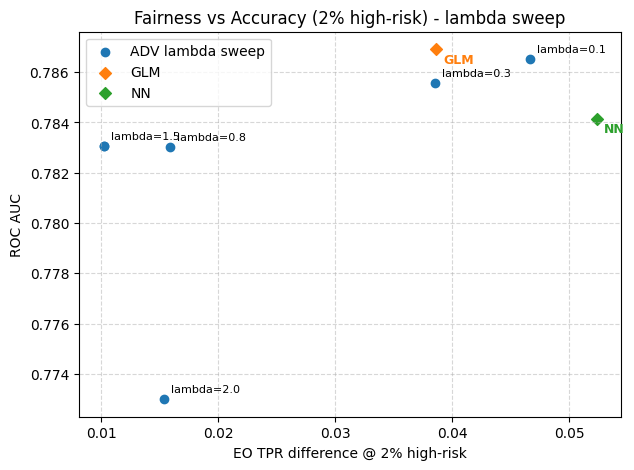

In [14]:
fig, ax = plt.subplots(figsize=(7,5))
ax.grid(True, linestyle='--', alpha=0.5)
lambda_pts = df_frontier_plot[df_frontier_plot['model']=='ADV_NN']
if not lambda_pts.empty:
    ax.scatter(lambda_pts['eo_gap_tpr'], lambda_pts['roc_auc'], c='tab:blue', label='ADV lambda sweep')
    for _, row in lambda_pts.iterrows():
        if pd.notna(row.get('lambda_adv')):
            ax.annotate(f"lambda={row['lambda_adv']}", (row['eo_gap_tpr'], row['roc_auc']), textcoords='offset points', xytext=(5,5), fontsize=8)
for model in ['GLM','NN']:
    subset = summary_fixed[summary_fixed['model']==model]
    if subset.empty:
        continue
    row = subset.iloc[0]
    ax.scatter(row['eo_gap_tpr'], row['roc_auc'], c=colors.get(model, 'tab:gray'), marker='D', label=model)
    ax.annotate(model, (row['eo_gap_tpr'], row['roc_auc']), textcoords='offset points', xytext=(5,-10), fontsize=9, fontweight='bold', color=colors.get(model, 'black'))
ax.set_xlabel('EO TPR difference @ 2% high-risk')
ax.set_ylabel('ROC AUC')
ax.set_title('Fairness vs Accuracy (2% high-risk) - lambda sweep')
ax.legend()
plt.show()


### 9.2 Fairness vs accuracy (2% high-risk, chosen lambda)


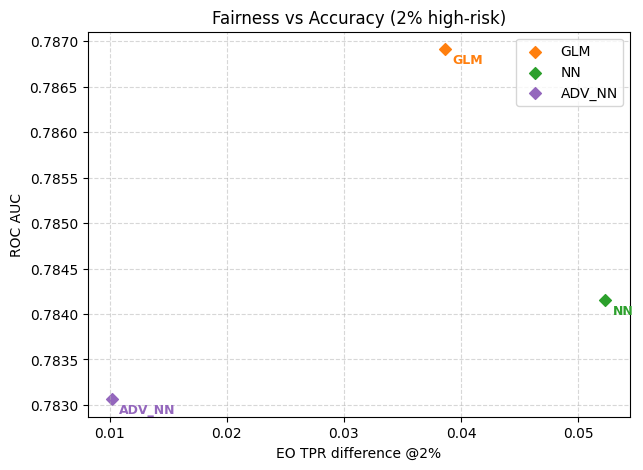

In [15]:
fig, ax = plt.subplots(figsize=(7,5))
ax.grid(True, linestyle='--', alpha=0.5)
for _, row in summary_fixed.iterrows():
    ax.scatter(row['eo_gap_tpr'], row['roc_auc'], color=colors.get(row['model'],'tab:blue'), marker='D', label=row['model'])
    ax.annotate(row['model'], (row['eo_gap_tpr'], row['roc_auc']), textcoords='offset points', xytext=(5,-10), fontsize=9, fontweight='bold', color=colors.get(row['model'],'black'))
ax.set_title('Fairness vs Accuracy (2% high-risk)')
ax.set_xlabel('EO TPR difference @2%')
ax.set_ylabel('ROC AUC')
ax.legend()
plt.show()


### 9.3 Fairness vs high-risk rate


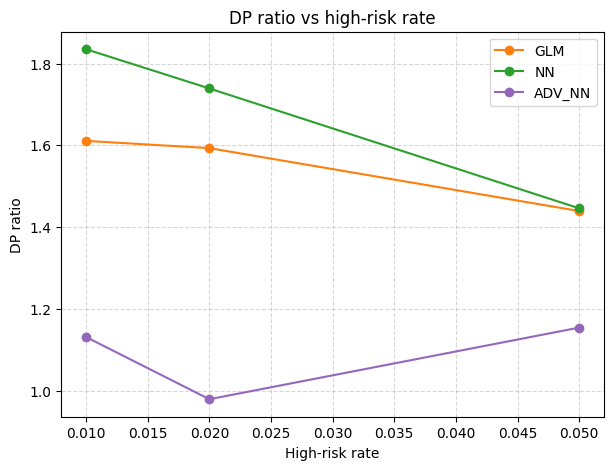

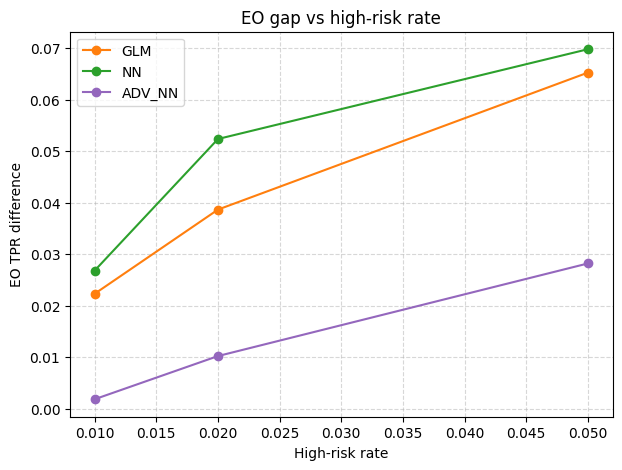

In [16]:
fig, ax = plt.subplots(figsize=(7,5))
for model, color in colors.items():
    subset = df_rates[df_rates['model']==model].sort_values('target_rate')
    ax.plot(subset['target_rate'], subset['dp_ratio'], marker='o', color=color, label=model)
ax.set_xlabel('High-risk rate')
ax.set_ylabel('DP ratio')
ax.set_title('DP ratio vs high-risk rate')
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(7,5))
for model, color in colors.items():
    subset = df_rates[df_rates['model']==model].sort_values('target_rate')
    ax.plot(subset['target_rate'], subset['eo_gap_tpr'], marker='o', color=color, label=model)
ax.set_xlabel('High-risk rate')
ax.set_ylabel('EO TPR difference')
ax.set_title('EO gap vs high-risk rate')
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.show()


### 9.4 Score distributions by group (GLM vs ADV_NN)


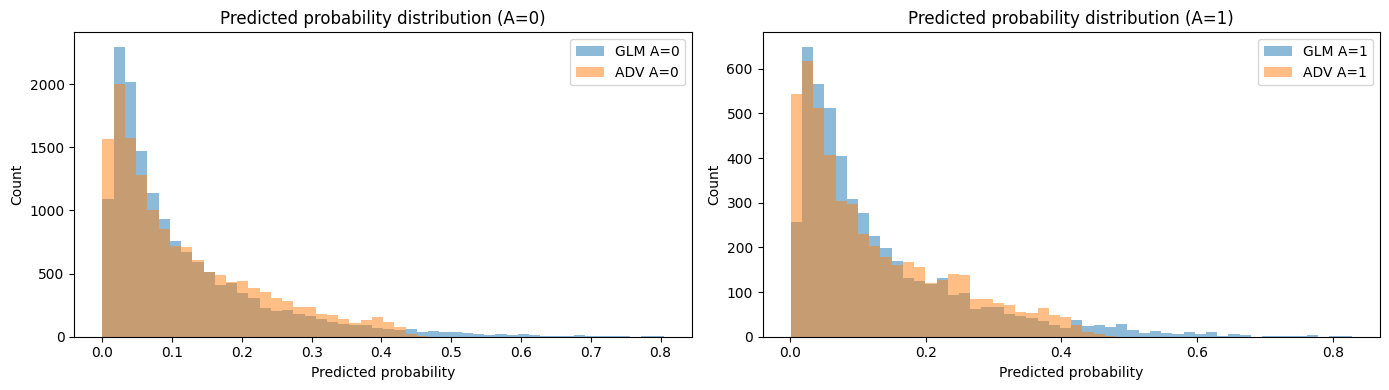

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for ax, group in zip(axes, [0, 1]):
    mask = (A_test == group)
    all_scores = np.concatenate([y_proba_glm[mask], y_proba_adv[mask]])
    bins = np.linspace(all_scores.min(), all_scores.max(), 51)
    ax.hist(y_proba_glm[mask], bins=bins, alpha=0.5, label=f'GLM A={group}')
    ax.hist(y_proba_adv[mask], bins=bins, alpha=0.5, label=f'ADV A={group}')
    ax.set_title(f'Predicted probability distribution (A={group})')
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('Count')
    ax.legend()
plt.tight_layout()
plt.show()


## 10. Simulated variable distributions


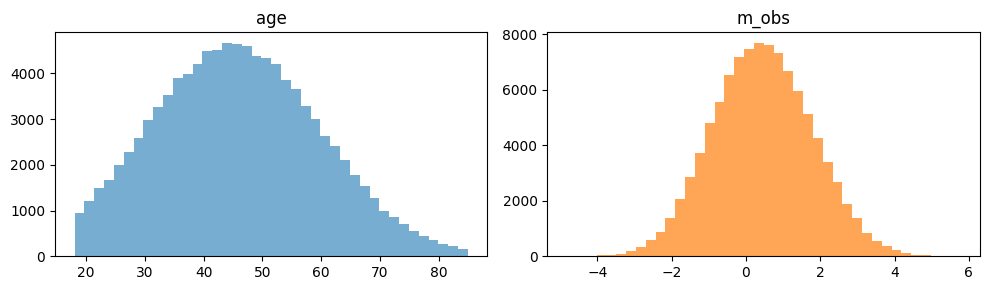

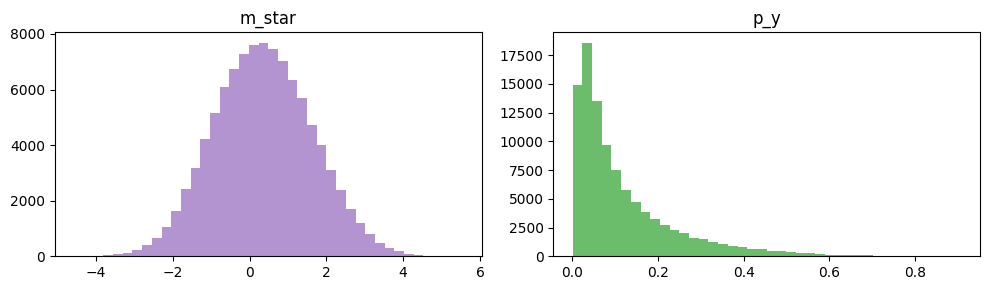

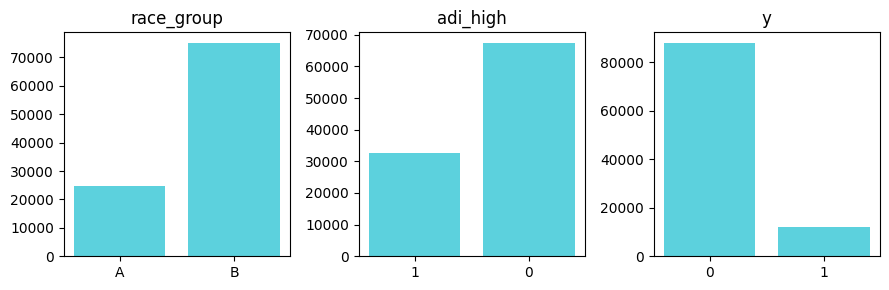

In [18]:
numeric_pairs_1 = ['age', 'm_obs']
numeric_pairs_2 = ['m_star', 'p_y']
binary_cols = ['race_group', 'adi_high', 'y']

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.ravel()
axes[0].hist(df[numeric_pairs_1[0]], bins=40, color='tab:blue', alpha=0.6)
axes[0].set_title(numeric_pairs_1[0])
axes[1].hist(df[numeric_pairs_1[1]], bins=40, color='tab:orange', alpha=0.7)
axes[1].set_title(numeric_pairs_1[1])
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.ravel()
axes[0].hist(df[numeric_pairs_2[0]], bins=40, color='tab:purple', alpha=0.7)
axes[0].set_title(numeric_pairs_2[0])
axes[1].hist(df[numeric_pairs_2[1]], bins=40, color='tab:green', alpha=0.7)
axes[1].set_title(numeric_pairs_2[1])
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(binary_cols), figsize=(3 * len(binary_cols), 3))
for ax, col in zip(axes, binary_cols):
    counts = df[col].value_counts().reindex(df[col].unique(), fill_value=0)
    ax.bar(counts.index.astype(str), counts.values, color='tab:cyan', alpha=0.7)
    ax.set_title(col)
plt.tight_layout()
plt.show()
